In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# HuggingFace transformers 설치 
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, ElectraModel, AdamW
from transformers import Trainer, TrainingArguments
from tqdm.notebook import tqdm
from torchsummary import summary

MODEL_NAME = "monologg/koelectra-base-v3-discriminator"

In [4]:
# cuda error 정보 가져오기
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
# GPU 사용
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [6]:
data_dir = '/content/drive/MyDrive/KMWP/code/data'
data = pd.read_csv(data_dir + '/new_train.csv')
data.head()

,index,class,problem,code,answer,Unnamed: 5
0,0,8,한 변의 길이가 24cm인 정육각형과 둘레가 같은 정팔각형이 있습니다. 이 정팔각형...,a = 24\nb = 6\nc = 8\ny = a * b // c\nprint(y),18,NaN
1,1,1,윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의...,a = 8\nb = 16\ny = b // a\nprint(y),2,NaN
2,2,8,"화단 주변에 한 변이 12m인 정팔각형 모양의 울타리를 두른다면, 울타리는 모두 몇...",a = 12\nb = 8\ny = a * b\nprint(y),96,NaN
3,3,3,"6장의 숫자 카드 0, 9, 8, 7, 2, 1가 있습니다. 이를, 한 번씩 사용하...",from itertools import permutations\n\na = ['0'...,987210,NaN
4,4,1,0.26 x 0.8을 계산해 주세요.,"a = 0.26\nb = 0.8\ny = a * b\nprint(""{:.2f}"".f...",0.21,NaN


class
1    1000
2      30
3     200
4     240
5     200
6     150
7     200
8     800
dtype: int64


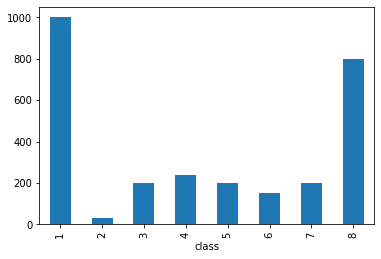

In [7]:
# Data Visualization 
class_count = data.groupby('class').size()
print(class_count)
class_count.plot(kind='bar')

In [8]:
# label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['class'])
num_labels = len(label_encoder.classes_)

data['label'] = np.asarray(label_encoder.transform(data['class']), dtype=np.int32)
data.head()

,index,class,problem,code,answer,Unnamed: 5,label
0,0,8,한 변의 길이가 24cm인 정육각형과 둘레가 같은 정팔각형이 있습니다. 이 정팔각형...,a = 24\nb = 6\nc = 8\ny = a * b // c\nprint(y),18,NaN,7
1,1,1,윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의...,a = 8\nb = 16\ny = b // a\nprint(y),2,NaN,0
2,2,8,"화단 주변에 한 변이 12m인 정팔각형 모양의 울타리를 두른다면, 울타리는 모두 몇...",a = 12\nb = 8\ny = a * b\nprint(y),96,NaN,7
3,3,3,"6장의 숫자 카드 0, 9, 8, 7, 2, 1가 있습니다. 이를, 한 번씩 사용하...",from itertools import permutations\n\na = ['0'...,987210,NaN,2
4,4,1,0.26 x 0.8을 계산해 주세요.,"a = 0.26\nb = 0.8\ny = a * b\nprint(""{:.2f}"".f...",0.21,NaN,0


In [9]:
# # class 1-8에서 0-7 범위로 변경
# data['class'] = data['class'].apply(lambda x : x-1)
# data.head()

In [10]:
data['class'].unique()

array([8, 1, 3, 7, 6, 5, 4, 2])

In [11]:
data['label'].unique()

array([7, 0, 2, 6, 5, 4, 3, 1], dtype=int32)

In [12]:
X = data['problem']
y = data['label']

In [13]:
print(X)
print(y)

0       한 변의 길이가 24cm인 정육각형과 둘레가 같은 정팔각형이 있습니다. 이 정팔각형...
1       윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의...
2       화단 주변에 한 변이 12m인 정팔각형 모양의 울타리를 두른다면, 울타리는 모두 몇...
3       6장의 숫자 카드 0, 9, 8, 7, 2, 1가 있습니다. 이를, 한 번씩 사용하...
4                                    0.26 x 0.8을 계산해 주세요.
                              ...                        
2815    10분 동안 6.53k미터를 가는 자동차와 20분 동안 15.12k미터를 가는 오토...
2816    한 면의 넓이가 81cm² 인 정육면체가 있습니다. 이 정육면체의 부피는 몇 cm³...
2817           4880보다 ○ 큰 수 는 9000입니다. ○안에 알맞은 수를 써 넣으시오.
2818    어느 문구점에서 연필 한 자루는 400원이고 공책 한 권은 1000원입니다. 현승이...
2819    초콜릿 44개를 상자 11개에 똑같이 나누어 담으려고 합니다. 한 상자에는 몇 개에...
Name: problem, Length: 2820, dtype: object
0       7
1       0
2       7
3       2
4       0
       ..
2815    0
2816    7
2817    0
2818    0
2819    0
Name: label, Length: 2820, dtype: int32


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.1,
                                                     shuffle=True,
                                                     random_state=1004)



In [15]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2538,)
X_test shape: (282,)
y_train shape: (2538,)
y_test shape: (282,)


In [16]:
train = pd.concat([X_train, y_train], axis=1, sort=True)
train

,problem,label
0,한 변의 길이가 24cm인 정육각형과 둘레가 같은 정팔각형이 있습니다. 이 정팔각형...,7
1,윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의...,0
2,"화단 주변에 한 변이 12m인 정팔각형 모양의 울타리를 두른다면, 울타리는 모두 몇...",7
3,"6장의 숫자 카드 0, 9, 8, 7, 2, 1가 있습니다. 이를, 한 번씩 사용하...",2
4,0.26 x 0.8을 계산해 주세요.,0
...,...,...
2815,10분 동안 6.53k미터를 가는 자동차와 20분 동안 15.12k미터를 가는 오토...,0
2816,한 면의 넓이가 81cm² 인 정육면체가 있습니다. 이 정육면체의 부피는 몇 cm³...,7
2817,4880보다 ○ 큰 수 는 9000입니다. ○안에 알맞은 수를 써 넣으시오.,0
2818,어느 문구점에서 연필 한 자루는 400원이고 공책 한 권은 1000원입니다. 현승이...,0


In [17]:
# sep_train = train.copy()
# sep_train = sep_train.rename(columns={'label':'class'})
# sep_train.head()

In [18]:
# sep_train.to_csv(data_dir + "/sep_train.csv", index=False)

In [19]:
test = pd.concat([X_test, y_test], axis=1, sort=True)
test

,problem,label
10,진호가 가진 줄자의 길이는 6m 15 cm 이고 두은이가 가진 줄자의 길이는 0.2...,0
36,농구공 18개를 보관함 3개에 똑같이 나누어 담으려고 합니다. 보관함 1개에 농구공...,0
41,승준이는 우유를 매일 0.7L씩 마십니다. 승준이가 5일 동안 마실 우유를 준비하려...,0
49,원 안에 마름모의 넓이가 90cm²일 때 원의 반지름은 몇 cm일까요?,7
71,"가로가 45센티미터, 세로가 50센티미터인 직사각형 모양의 종이를 크기가 같은 정사...",7
...,...,...
2777,냉장고에 우유가 3L 있었습니다. 은채는 오늘 우유 전체의 1/3를 마셨습니다. 은...,0
2780,"가로가 6센티미터, 세로가 3센티미터인 직육면체가 있습니다. 이 직육면체의 부피가 ...",7
2786,고리에 걸릴 때마다 3점씩 얻고 걸리지 않으 면 2점씩 잃는다고 합니다. 윤지는 고...,0
2791,"냉장고에 우유가 4리터 있었습니다. 세은이는 우유 전체의 1/4을 마셨다면, 세은이...",0


In [20]:
#test.to_csv(data_dir + "/sep_test.csv", index=False)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   problem  2538 non-null   object
 1   label    2538 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 49.6+ KB


In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 10 to 2796
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   problem  282 non-null    object
 1   label    282 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 5.5+ KB


In [23]:
train.iloc[1,0:2].values

array(['윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의 부추전을 똑같이 16 조각으로 나누었습니다. 윤아와 같은 양을 먹으려면 윤미는 몇 조각을 먹어야 할까요?',
       0], dtype=object)

In [24]:
train.iloc[1,0:2].values[0]

'윤아는 부추전을 똑같이 8조각으로 나누어 한 조각을 먹었습니다. 윤미는 같은 크기의 부추전을 똑같이 16 조각으로 나누었습니다. 윤아와 같은 양을 먹으려면 윤미는 몇 조각을 먹어야 할까요?'

In [25]:
train.iloc[1,0:2].values[1]

0

In [26]:
len(train['label'].unique())

8

In [27]:
len(label_encoder.classes_)

8

# 데이터셋 불러오기

In [28]:
class mpDataset(Dataset):
  
  def __init__(self, dataset):
    # 일부 값중에 NaN이 있다면 drop
    self.dataset = dataset
    self.num_labels = len(label_encoder.classes_)
    self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=self.num_labels)


    print(self.dataset.describe())
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    #print(row)
    text = row[0]
    #print(text)
    y = row[1]
    #print(y)

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    #print(input_ids)
    attention_mask = inputs['attention_mask'][0]
    #print(attention_mask)
    #print(input_ids.size())
    #print(attention_mask.size())

    return input_ids, attention_mask, y

In [29]:
train_dataset = mpDataset(train)
test_dataset = mpDataset(test)

             label
count  2538.000000
mean      3.390071
std       2.931072
min       0.000000
25%       0.000000
50%       3.000000
75%       7.000000
max       7.000000
            label
count  282.000000
mean     3.177305
std      3.000080
min      0.000000
25%      0.000000
50%      3.000000
75%      7.000000
max      7.000000


In [30]:
train_dataset[0]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(tensor([    2,  3757, 10084,  7918,  4070,  6592,  4051,  4036,  4139, 26112,
         22720,  4047, 16740,  4070,  2024,  4112,  3286,  4264, 22720,  4007,
          3249,  4576,  6216,    18,  3240,  3286,  4264, 22720,  4234,  3757,
         10084,  7918,  4034,  2676,  9612, 13830,  8597,  8213,    18,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

# 모델 만들기

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=8).to(device)

# 한번 실행해보기
text, attention_mask, y = train_dataset[0]
model(text.unsqueeze(0).to(device), attention_mask=attention_mask.unsqueeze(0).to(device))

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

SequenceClassifierOutput([('logits',
                           tensor([[-0.0900,  0.0863,  0.0021,  0.0210,  0.0368, -0.1359, -0.0014,  0.0941]],
                                  device='cuda:0', grad_fn=<AddmmBackward0>))])

In [32]:
torch.save(model.state_dict(),"model.pt")

In [33]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [34]:
# 모델 레이어 보기
model.eval()

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

# 학습하기

In [35]:
epochs = 5
batch_size = 16

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [37]:
train_loader

In [38]:
losses = []
accuracies = []


# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0


  model.to(device)
  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    
    y_batch = y_batch.type(torch.LongTensor)
    y_batch = y_batch.to(device)
    #print(y_batch)
    #print("y_batch의 데이터 타입:")
    #print(y_batch[0].dtype,y_batch.shape)
    
    #print("------------")
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    #print(y_pred)
    #print("y_predict의 데이터 타입:")
    #print(y_pred[0].dtype)
    #print("Input_ids_batch:", input_ids_batch)
    #print("Attention_masks_batch size:", len(attention_masks_batch))

    #loss = F.cross_entropy(y_pred, y_batch)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, y_batch)
    #print(loss)
    
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)


    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/159 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 188.12630569934845 Accuracy: tensor(0.4500, device='cuda:0')
Train Loss: 281.176198720932 Accuracy: tensor(0.5067, device='cuda:0')


  0%|          | 0/159 [00:00<?, ?it/s]

Batch Loss: 127.36570358276367 Accuracy: tensor(0.6506, device='cuda:0')
Train Loss: 190.06548178195953 Accuracy: tensor(0.6860, device='cuda:0')


  0%|          | 0/159 [00:00<?, ?it/s]

Batch Loss: 90.08372840285301 Accuracy: tensor(0.8125, device='cuda:0')
Train Loss: 134.55680778622627 Accuracy: tensor(0.8274, device='cuda:0')


  0%|          | 0/159 [00:00<?, ?it/s]

Batch Loss: 66.27016380429268 Accuracy: tensor(0.8944, device='cuda:0')
Train Loss: 101.82620692253113 Accuracy: tensor(0.8964, device='cuda:0')


  0%|          | 0/159 [00:00<?, ?it/s]

Batch Loss: 51.4068479090929 Accuracy: tensor(0.9162, device='cuda:0')
Train Loss: 81.45434020459652 Accuracy: tensor(0.9133, device='cuda:0')


### 에러 발생 1
PyTorch RuntimeError: unique_by_key: failed to synchronize: cudaErrorAssert: device-side assert triggered
- 해결방법
[https://stackoverflow.com/questions/68277801/extracting-meaningful-error-message-from-runtimeerror-cuda-error-device-side]

### 에러 발생 2
RuntimeError: stack expects each tensor to be equal size, but got [43] at entry 0 and [61] at entry 1
- input이 이상하게 들어간거 같음

### 에러 해결한 방법
1. y_batch의 타입 변경 <br>
``y_batch = y_batch.type(torch.LongTensor)``
2. KoELECTRA 모델 사용 시 label이 2개 이상일 경우 인자로 num_labels 넣어줘야함!!!! <br>
``model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=8).to(device)``

In [39]:
losses, accuracies

([281.176198720932,
  190.06548178195953,
  134.55680778622627,
  101.82620692253113,
  81.45434020459652],
 [tensor(0.5067, device='cuda:0'),
  tensor(0.6860, device='cuda:0'),
  tensor(0.8274, device='cuda:0'),
  tensor(0.8964, device='cuda:0'),
  tensor(0.9133, device='cuda:0')])

In [40]:
model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy: tensor(0.9078, device='cuda:0')


In [41]:
# 모델 저장하기
save_model_path = data_dir + '/_weights'
if os.path.exists(save_model_path) == False:
    os.mkdir(save_model_path)  	
torch.save(model.state_dict(), os.path.join(save_model_path, "koelectra-base-finetuned-mathProblem.bin"))